# Conduit Experiment Analysis

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sp
import sympy as sym
import math

### Plot of theoretical speed-amplitude relation

In [47]:
avals = np.linspace(1.1, 30, 100)
cvals = (avals**2 * np.log(avals**2) - avals**2 + 1) / ((avals-1)**2)

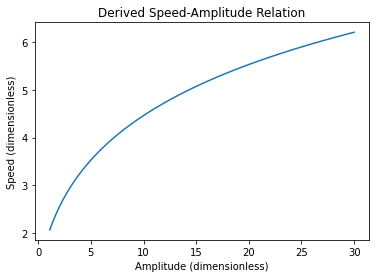

In [39]:
plt.plot(avals,cvals)
plt.ylabel('Speed (dimensionless)')
plt.xlabel('Amplitude (dimensionless)')
plt.title('Derived Speed-Amplitude Relation')
plt.show()

### Initial observations of Conduit-Experiment Data 

In [49]:
# Data dictionary
dict10 = sp.loadmat('expData10.mat')
dict10['Amat'].ndim

2

In [50]:
# Amplitude Matrix
mat10 = dict10['Amat']
mat10.shape

(273, 4418)

In [51]:
dict10['A0'][0,0]

4.16

In [52]:
dict10['A0_error'][0,0]

0.6

In [53]:
# dict10['t_vec']

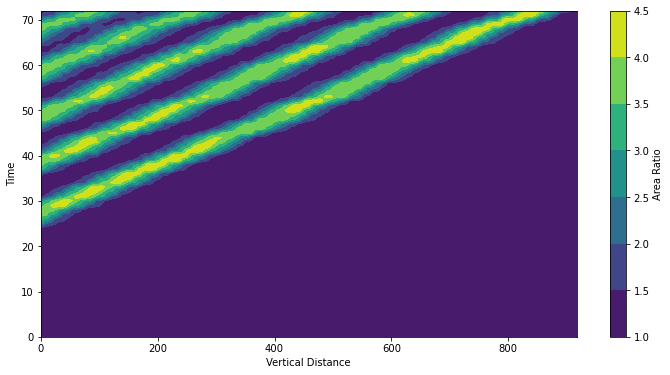

In [54]:
plt.figure(figsize = (12,6))

# [:100, :100]

plt.contourf(mat10[200:, 3500:])
plt.colorbar(label = 'Area Ratio')
plt.xlabel('Vertical Distance')
plt.ylabel('Time')

plt.show()

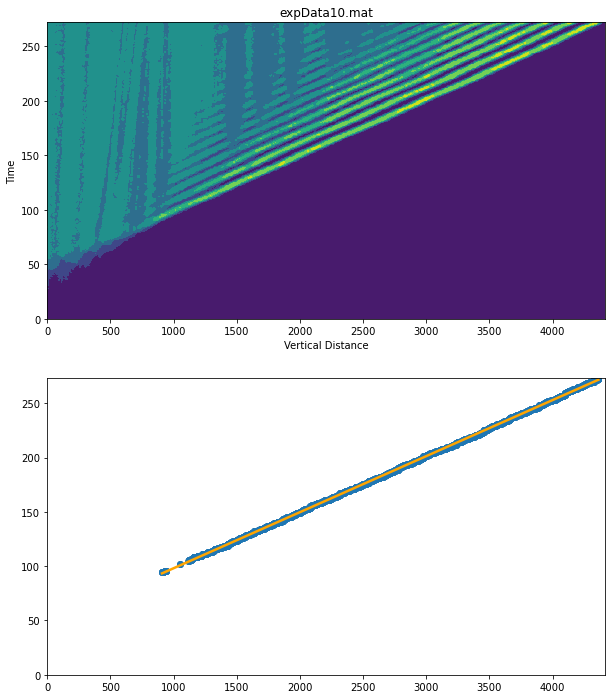

In [55]:
data = 'expData' + str(10) + '.mat'
dictionary = sp.loadmat(data)
a0 = dictionary['A0'][0,0]

new_dict = compute_soliton_speed(dictionary)

#make two plots side by side
m = (1 / new_dict['index_speed'])
y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]

plt.figure(figsize = (10, 12))

plt.subplot(2, 1, 1)
plt.contourf(dictionary['Amat'])
plt.xlabel('Vertical Distance')
plt.ylabel('Time')
plt.title(data)

plt.subplot(2, 1, 2)
plt.scatter(*zip(*new_dict['solitonIdxs']))
plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
plt.xlim(0,dictionary['z_vec'].size)
plt.ylim(0,dictionary['t_vec'].size)

plt.show()

### Building the function

In [11]:
# for each vertical distance coordinate where there is a possible soliton index, take the smallest index from that
## list, generate a list of all the points of the soliton to find a more accurate slope

In [58]:
fullWaveIdxs = []                  # first get possible soliton indexes
for i in range(227):
    for j in range(4418):
        if (mat10[i,j]>8.26) & (mat10[i,j]<8.66):
            fullWaveIdxs.append((i,j))

In [59]:
solitonIdxs = []
dists = [idx[1] for idx in fullWaveIdxs]
for d in set(dists):
    column_idxs = [idx for idx in fullWaveIdxs if idx[1] == d]
    solitonIdxs.append(min(column_idxs))

In [60]:
dists = [idx[1] for idx in fullWaveIdxs]
# set(dists)

In [61]:
# solitonIdxs[40:50]

In [62]:
solitonIdxs = [(idx[1],idx[0]) for idx in solitonIdxs]
# solitonIdxs[40:50]

In [63]:
xvals = [idx[0] for idx in solitonIdxs]
yvals = [idx[1] for idx in solitonIdxs]

In [18]:
# solitonIdxs[40:50]

In [64]:
# 1/m

# Function

In [65]:
def compute_soliton_speed(dictionary):
    mat = dictionary['Amat']
    times = mat.shape[0]
    distances = mat.shape[1]
    a0 = dictionary['A0'][0,0]
    a0_error = dictionary['A0_error'][0,0]
    solitonAmpRange = ((a0 - a0_error), (a0 + a0_error))
    
    # first get possible soliton indexes
    fullWaveIdxs = []                    
    for i in range(times):
        for j in range(distances):
            if (mat[i,j]>solitonAmpRange[0]) & (mat[i,j]<solitonAmpRange[1]):
                fullWaveIdxs.append((i,j))
                
    # next, get the index with the smallest time coordinate from every column where there is a soliton
    solitonIdxs = []           
    columns = [idx[1] for idx in fullWaveIdxs]                  
    for d in set(columns):
        column_idxs = [idx for idx in fullWaveIdxs if idx[1] == d]
        solitonIdxs.append(min(column_idxs))
        
    # change order of the coordinates for each soliton index to switch from matrix indexing to cartesian coordinates
    solitonIdxs = [(idx[1],idx[0]) for idx in solitonIdxs]

    # separate the time values and the distance values for use of polyfit() function
    xvals = [idx[0] for idx in solitonIdxs]
    yvals = [idx[1] for idx in solitonIdxs]
    m, b = np.polyfit(xvals, yvals, deg = 1)
    
    # calculating real_speed by adjusting scales of the matrix indices
    index_speed = 1/m    # zidx / tidx
    cm_per_zidx = dictionary['z_vec'][-1][-1] / dictionary['z_vec'].size
    real_distance = index_speed * cm_per_zidx  # cm / tidx
    sec_per_tidx = dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size
    
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size > 0:  # in case the time vector has negative time values
        average = 1.2371625245444737
        sec_per_tidx = average
    
    real_speed = real_distance / sec_per_tidx  # cm / sec
    
    # return all useful information for tracking speed and for plotting 
    return {'real_speed':real_speed, 'index_speed':index_speed,
            'solitonIdxs':solitonIdxs, 'xvals':xvals, 'yvals':yvals, 'b':b}

### Noticing negative values in the time vectors of some of our data sets.

In [24]:
for num in range(7,10):
    data = 'expData0' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size > 0:
        print('True', num)

for num in range(10,14):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size > 0:
        print('True', num)
    
for num in range(17,49):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size > 0:
        print('True', num)

True 7
True 35


Two of our 39 datasets have negative numbers in the time vectors. I believe that this is just some odd experimental measurement error. All the other datasets have similar, monotonic time vectors. 
Because of this, I will find the average time adjustment from all the other datasets and apply this average to the 2 datasets with botched time vectors. 

In [25]:
# sec_per_tidx = dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size
sec_per_tidx_list = []
for num in range(7,10):
    data = 'expData0' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size == 0:
        sec_per_tidx_list.append(dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size)

for num in range(10,14):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size == 0:
        sec_per_tidx_list.append(dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size)
    
for num in range(17,49):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size == 0:
        sec_per_tidx_list.append(dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size)

average = sum(sec_per_tidx_list) / len(sec_per_tidx_list)
average

1.2371625245444737

### Examining specific solitons
* experiment 12 does is not compatible with the compute_speed function 
* experiment 7 has negative time values in its time vector thus needs to be scaled with the average scaling factor 

In [9]:
dict35 = sp.loadmat('expData35.mat')
# dict35

In [29]:
dict35['t_vec'].max() - dict35['t_vec'].min()   # the experiment did not last 3600 seconds, 1 hour

3599.0

In [8]:
dict07 = sp.loadmat('expData07.mat')
# dict07

In [13]:
# dict07['t_vec'][dict07['t_vec'] < 0].size

In [30]:
dict07 = sp.loadmat('expData07.mat')
dict07['t_vec'].min()

-3543.33

In [31]:
dict07['t_vec'].max()

55.67000000000007

In [9]:
mat07 = dict07['Amat']
# mat07.shape

In [3]:
# dict07['t_vec'].size

In [4]:
# dict07['t_vec'][-1][-1]

In [5]:
# dict07['z_vec'].size

In [6]:
# dict07['z_vec'][-1][-1]

In [39]:
dict12 = sp.loadmat('expData12.mat')
# dict07

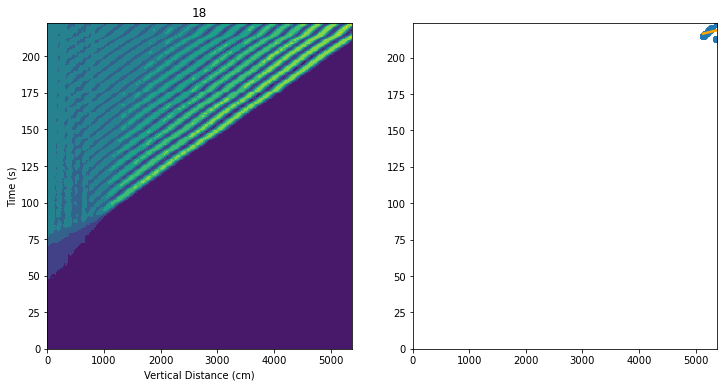

In [40]:
dictionary = dict12
a0 = dictionary['A0'][0,0]

new_dict = compute_soliton_speed(dictionary)
m = (1 / new_dict['index_speed'])



y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]

plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.contourf(dictionary['Amat'])
plt.xlabel('Vertical Distance (cm)')
plt.ylabel('Time (s)')
plt.title('18')

plt.subplot(1, 2, 2)
plt.scatter(*zip(*new_dict['solitonIdxs']))
plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
plt.xlim(0,dictionary['z_vec'].size)
plt.ylim(0,dictionary['t_vec'].size)
plt.show()

In [41]:
# new_dict['xvals']

In [42]:
new_dict['index_speed']

107.41704988635082

In [43]:
cm_per_zidx = dict07['z_vec'][-1][-1] / dict07['z_vec'].size
cm_per_zidx

0.025584207786328656

In [44]:
real_distance = new_dict['index_speed'] * cm_per_zidx
real_distance

2.7481801240868307

In [45]:
sec_per_tidx = dict07['t_vec'][-1][-1] / dict07['t_vec'].size
sec_per_tidx

-14.578590308370044

In [46]:
real_speed = real_distance / sec_per_tidx
real_speed

-0.18850794665030204

# Finding speeds of all the solitons

In [3]:
speeds_list = []
a0_list = []
u0_list = []

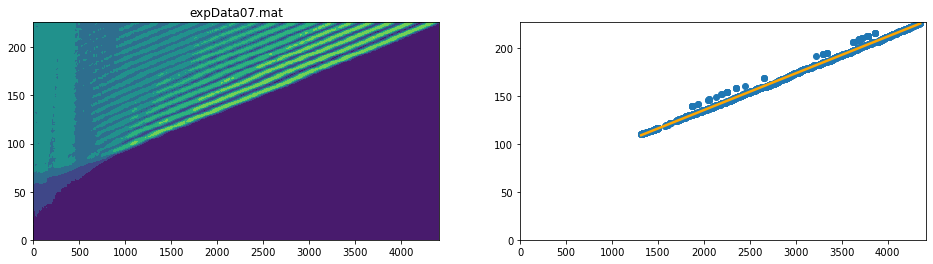

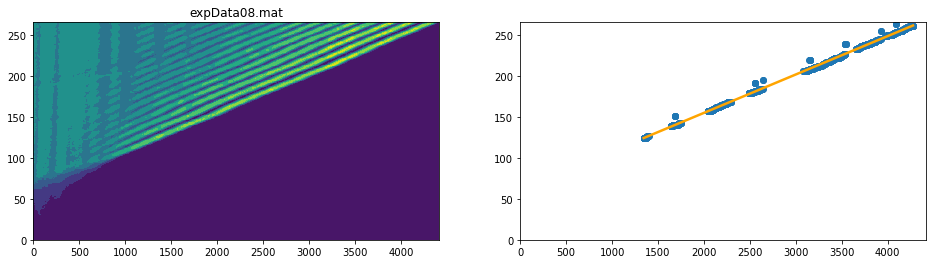

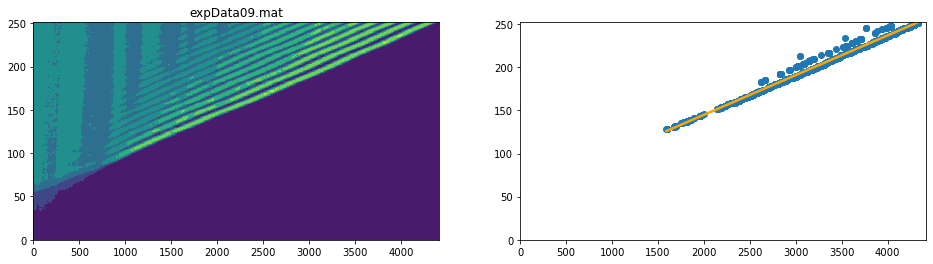

In [4]:
# data sets [7-9]
for num in range(7,10):
    data = 'expData0' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_list.append((num, a0))
    u0_list.append(dictionary['U0'][0,0])
    
    new_dict = compute_soliton_speed(dictionary)
    
    # append speed to list
    speeds_list.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (16, 4))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()    

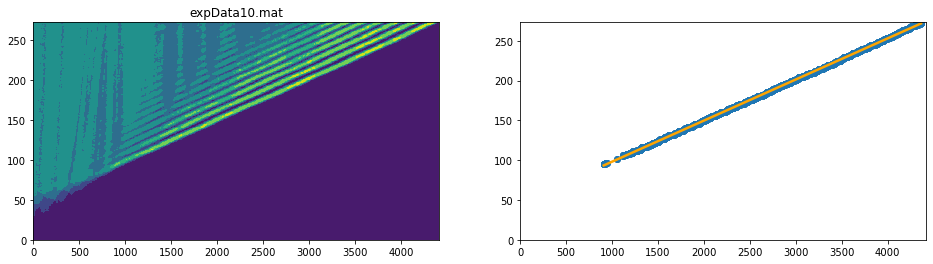

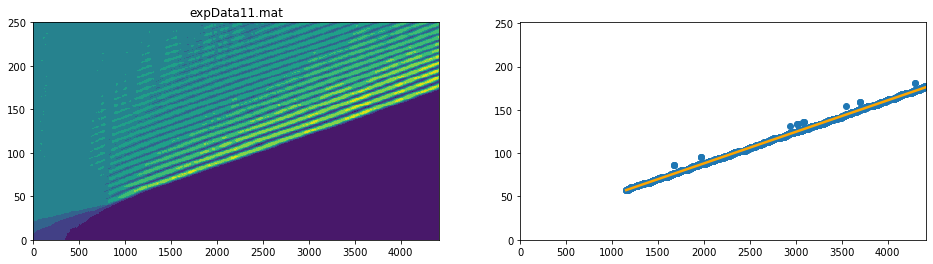

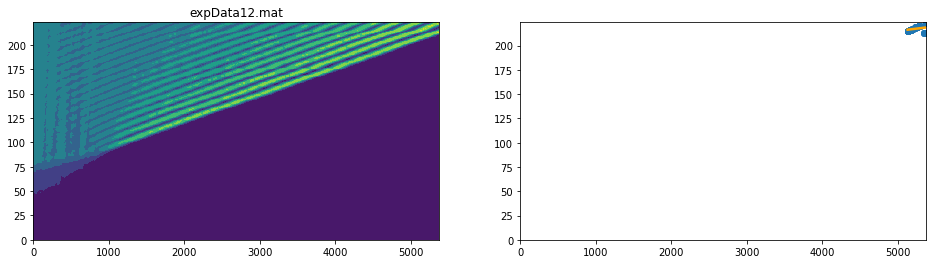

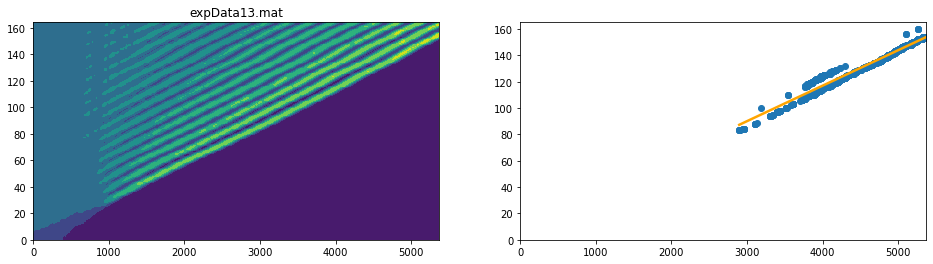

In [5]:
# data sets [10-13]
for num in range(10,14):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_list.append((num, a0))
    u0_list.append(dictionary['U0'][0,0])
    
    new_dict = compute_soliton_speed(dictionary)
    
    # append speed to list
    speeds_list.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (16, 4))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])

    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()

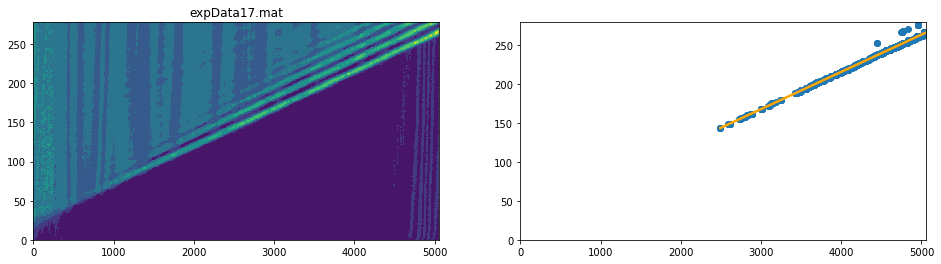

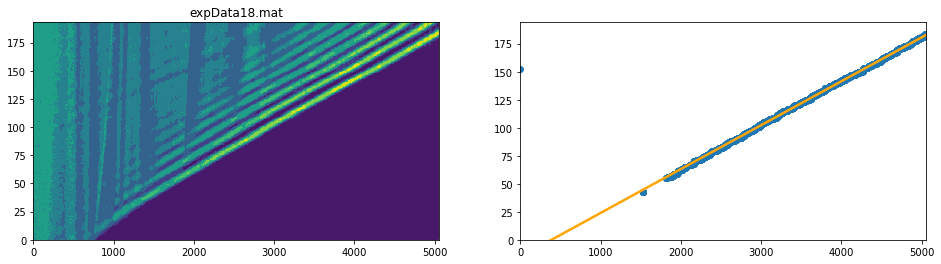

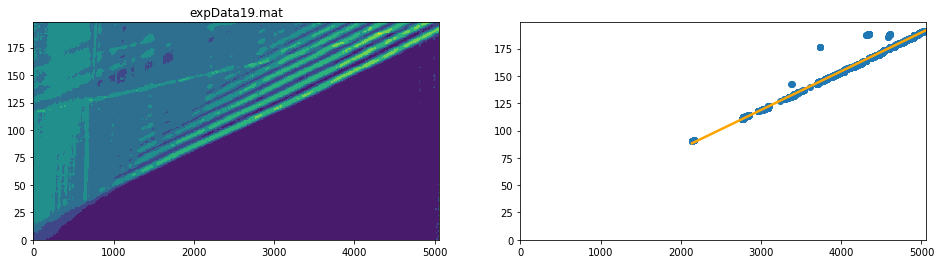

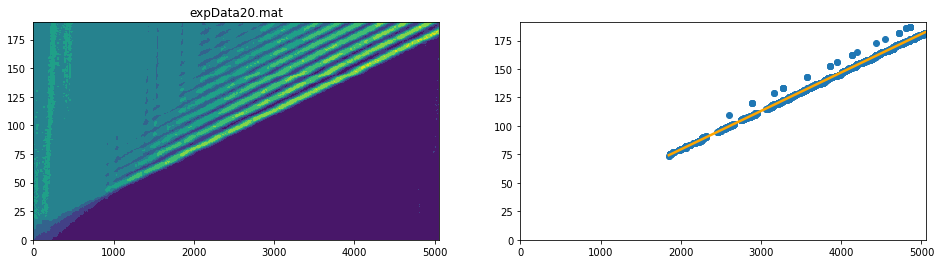

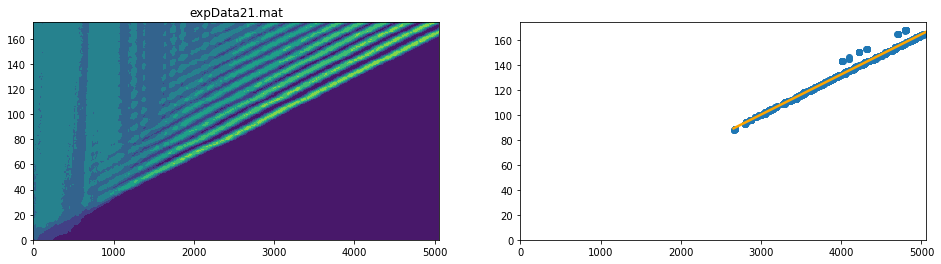

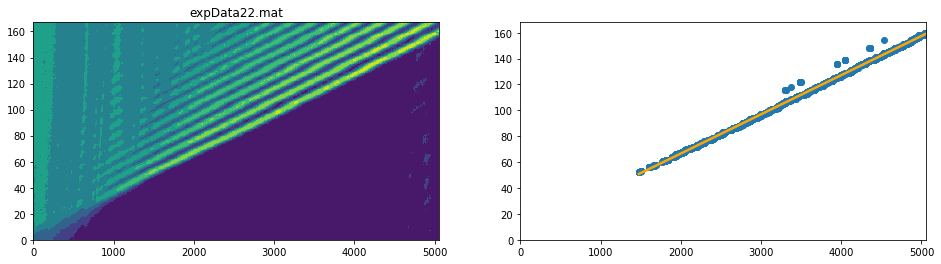

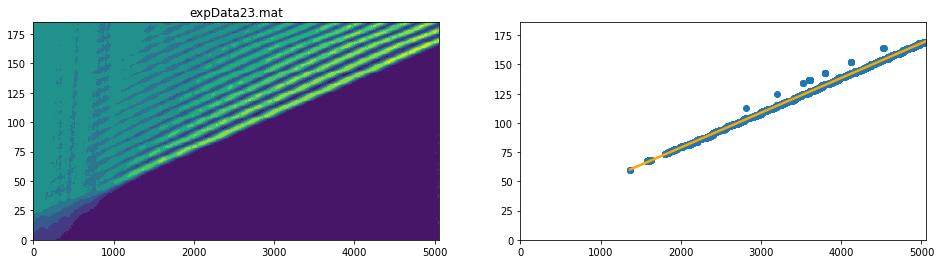

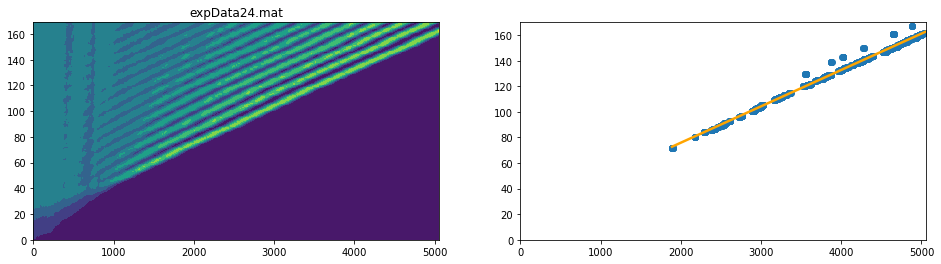

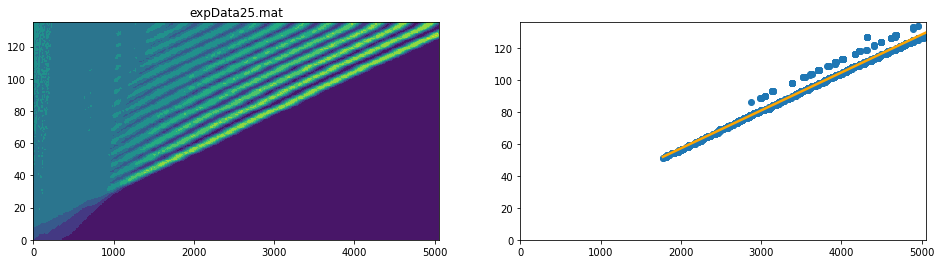

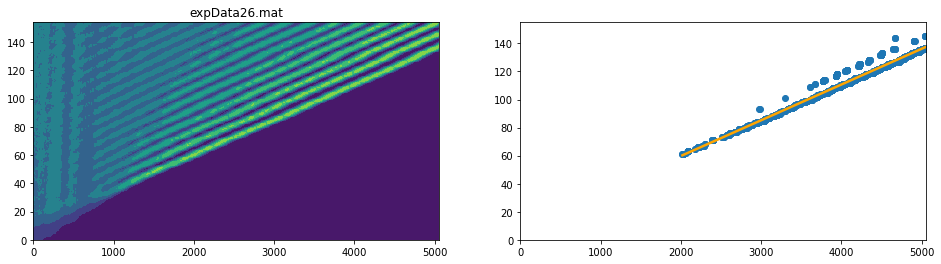

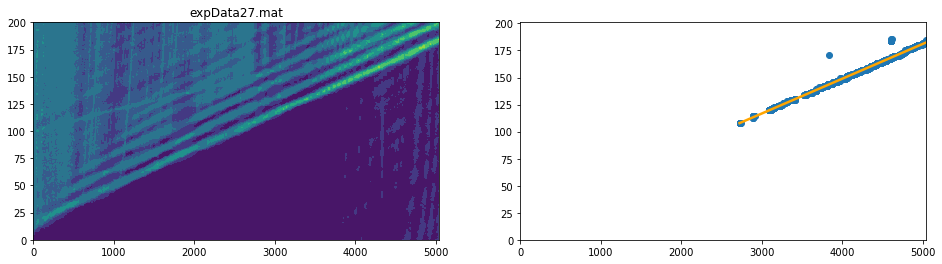

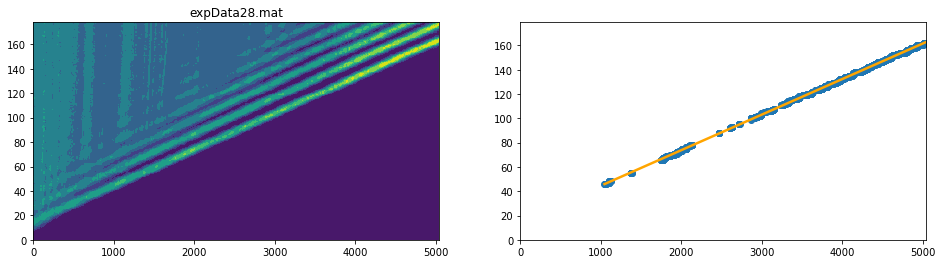

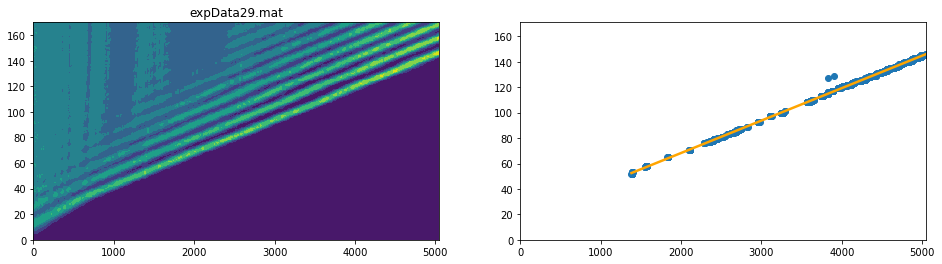

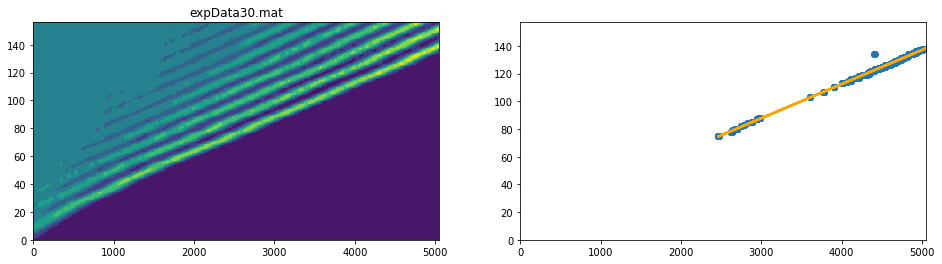

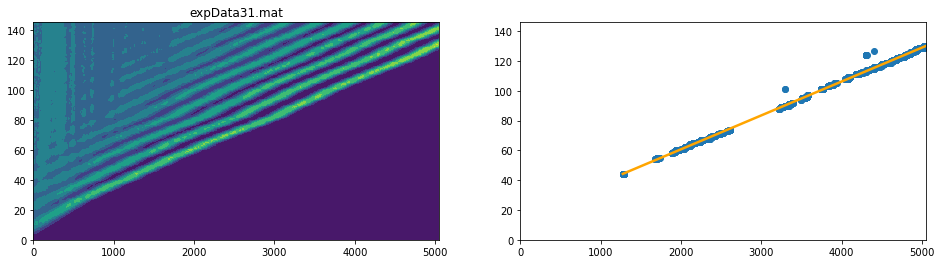

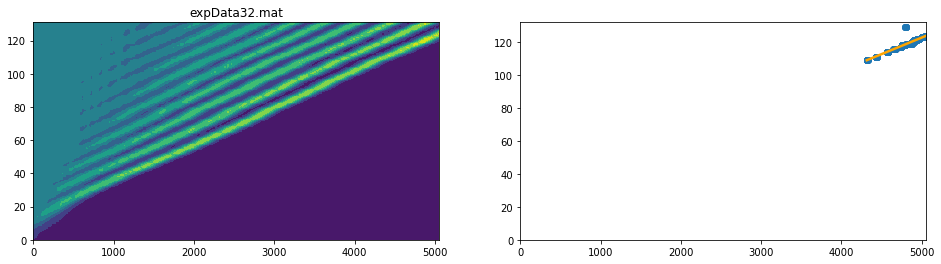

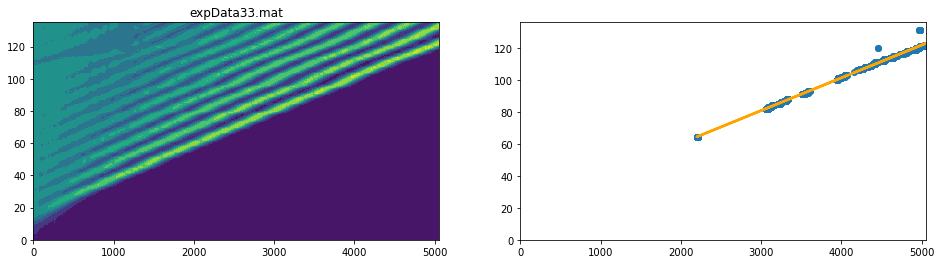

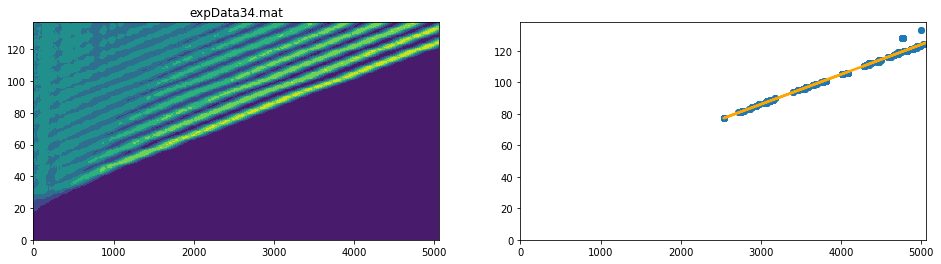

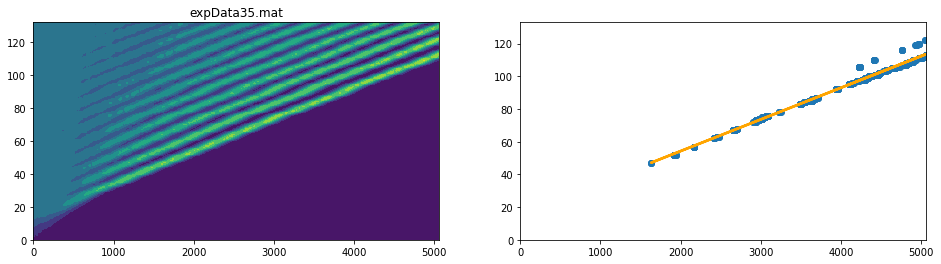

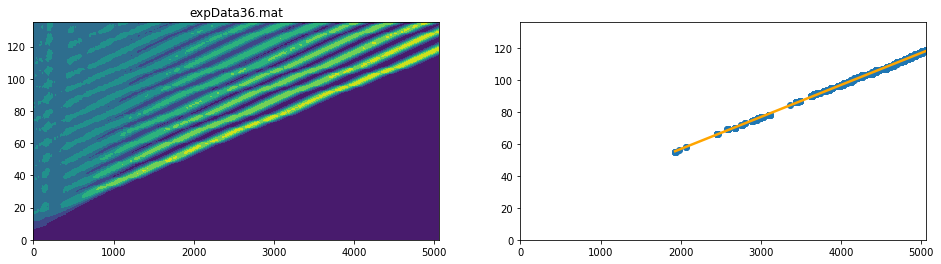

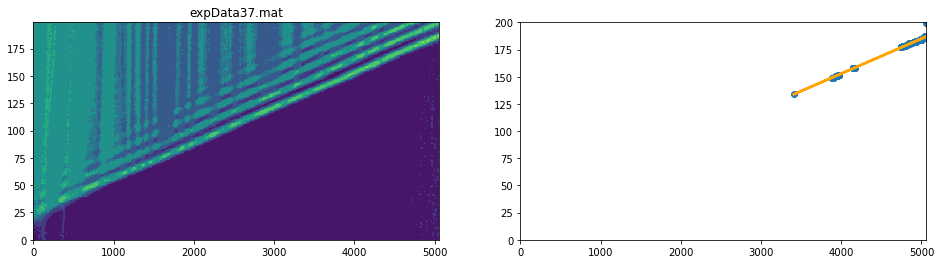

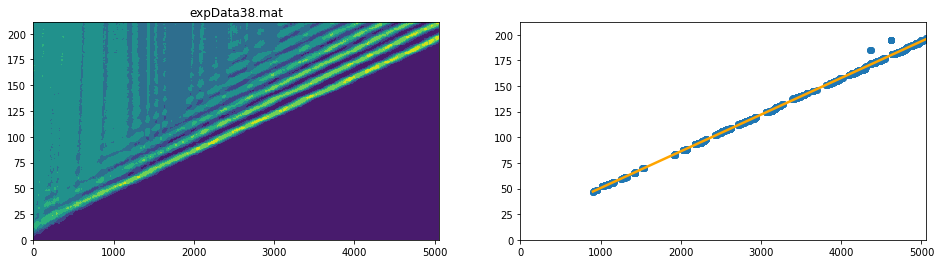

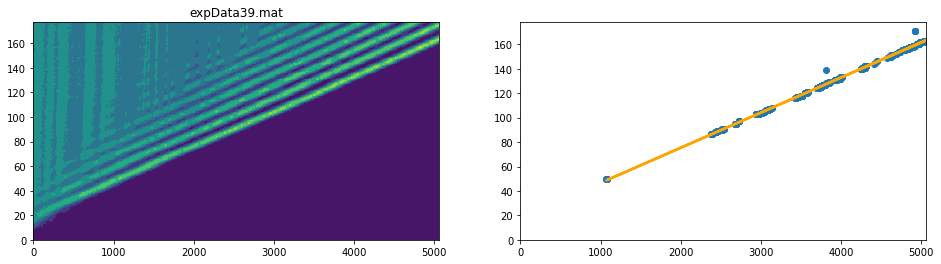

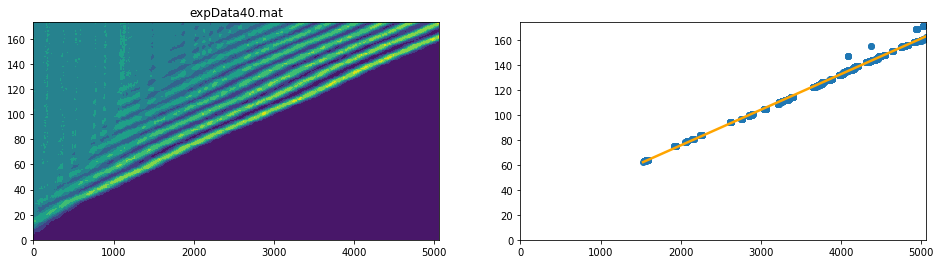

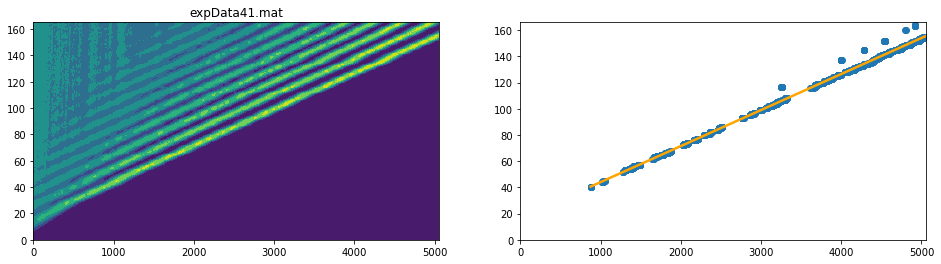

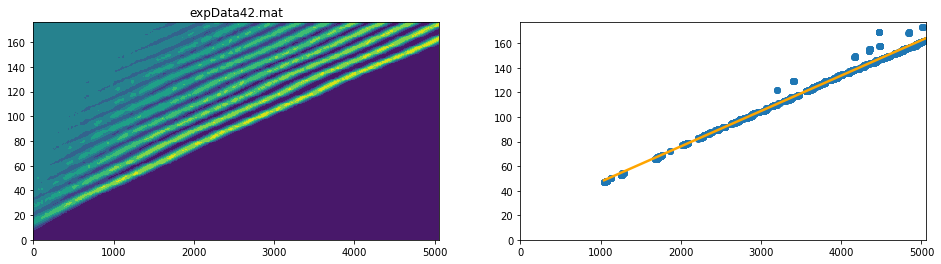

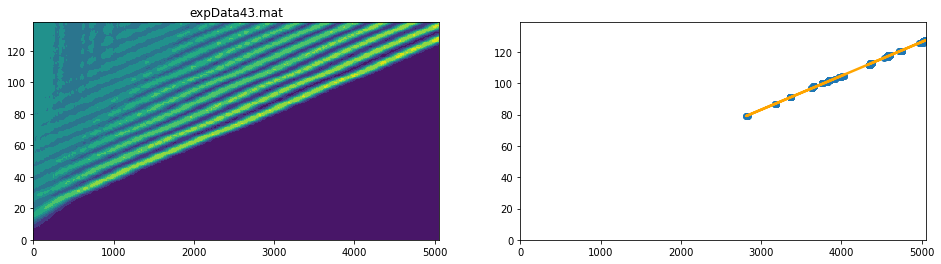

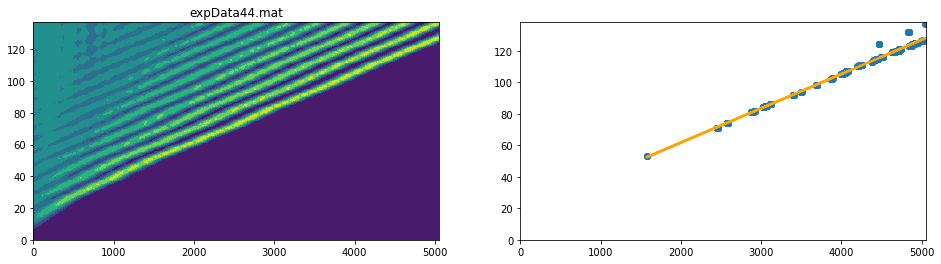

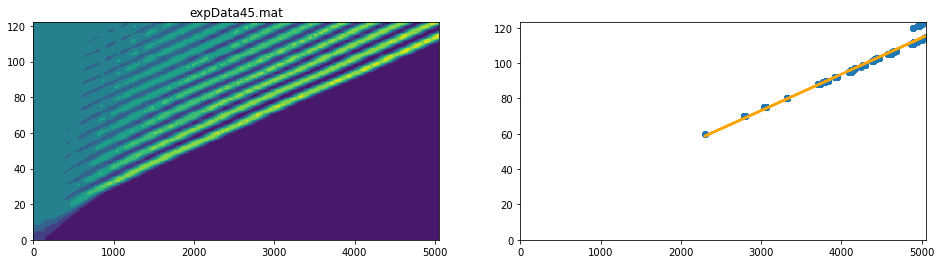

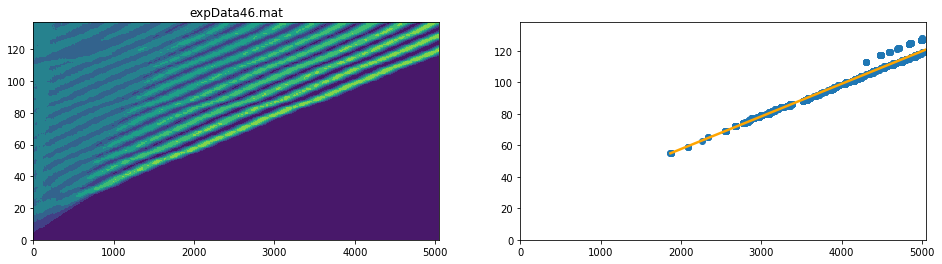

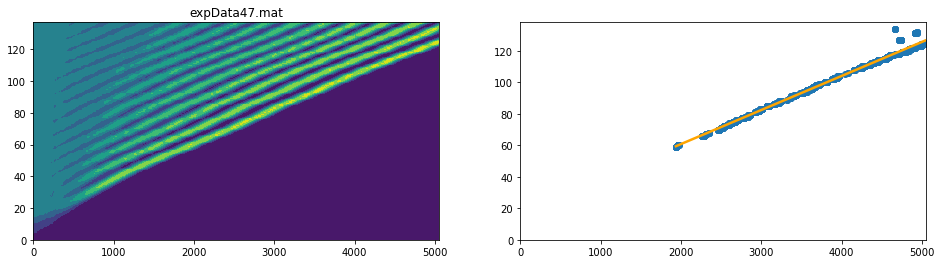

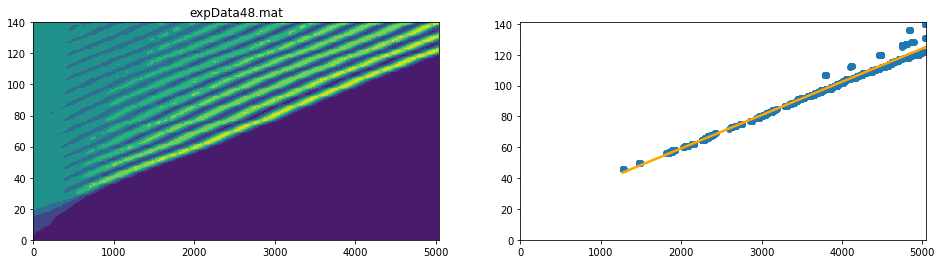

In [6]:
# data sets [17-48]
for num in range(17,49):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_list.append((num, a0))
    u0_list.append(dictionary['U0'][0,0])
    
    new_dict = compute_soliton_speed(dictionary)
    
    # append speed to list
    speeds_list.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (16, 4))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])

    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()

**Datasets the function worked well on**
* 43, 36, 28, 18, 10, 7, 38, 30, 29, 27, 22, 31, 11, 8

In [81]:
# a0_list

* Now need to figure out how to compare the experimental speeds to the theoretical speeds <br>
* For each experimental A0, find the value of the theoretical c(A0) and associated error, and then scale by multiplying this c(A0) to the corresponding U0 value given in each data set

### Building a list of the theoretical speeds

In [7]:
# u0_list

In [8]:
# a0_list

In [9]:
# finding the dimensionalized theoretical speeds for comparison to the experimentally found speeds
theo_speeds_list = []
for a0 in a0_list:
    theo_speed = (a0[1]**2 * np.log(a0[1]**2) - a0[1]**2 + 1) / ((a0[1]-1)**2)
    theo_speeds_list.append(theo_speed)

theo_speeds_arr = np.array(theo_speeds_list)
corresponding_u0_arr = np.array(u0_list)
scaled_theos = theo_speeds_arr * corresponding_u0_arr

In [10]:
# adding the a0 value and dataset number to the scaled_theos_list
scaled_theos_list = scaled_theos.tolist()
for i in range(len(a0_list)):
    scaled_theos_list[i] = (a0_list[i][1], scaled_theos_list[i], a0_list[i][0])
# scaled_theos_list

**checking work**

In [117]:
dict10 = sp.loadmat('expData10.mat')
a0 = dict10['A0']
u0 = dict10['U0']
print('a0=', a0[0,0])
print('u0=', u0[0,0])
scaled_theo_speed10 = (a0**2 * np.log(a0**2) - a0**2 + 1) / ((a0-1)**2) * u0
scaled_theo_speed10

a0= 4.16
u0= 0.12938929125181425


array([[0.42803043]])

Can see below that each speed in scaled_theos_list matches its corresponding A0 value.

In [11]:
speeds_list.sort()
# speeds_list

In [12]:
scaled_theos_list.sort()
# scaled_theos_list

### Plotting experimental speed-amplitude relation from all the data

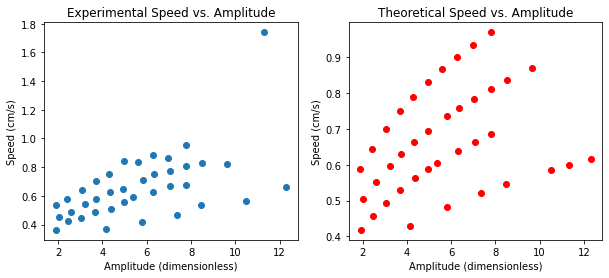

In [66]:
# PLOTTING
plt.figure(figsize = (10,4))

# experimental speeds
plt.subplot(1,2,1)
x,y,z = zip(*speeds_list)
plt.scatter(x, y)
plt.ylabel('Speed (cm/s)')
plt.xlabel('Amplitude (dimensionless)')
plt.title('Experimental Speed vs. Amplitude')

# theoretical speeds
plt.subplot(1,2,2)
theo_a0, theo_speed, dataset = zip(*scaled_theos_list)
plt.plot(theo_a0, theo_speed, 'o', c = 'red')
plt.ylabel('Speed (cm/s)')
plt.xlabel('Amplitude (dimensionless)')
plt.title('Theoretical Speed vs. Amplitude')

plt.show()

**Notice there are is one bad outlier. If we remove this points from the plot...** 

In [67]:
# define a new speeds_list with desired data sets
speeds_list2 = [(speeds_list[i]) for i in range(37)]
speeds_list2.append(speeds_list[38])
# speeds_list2

**All the speeds besides one outlier**

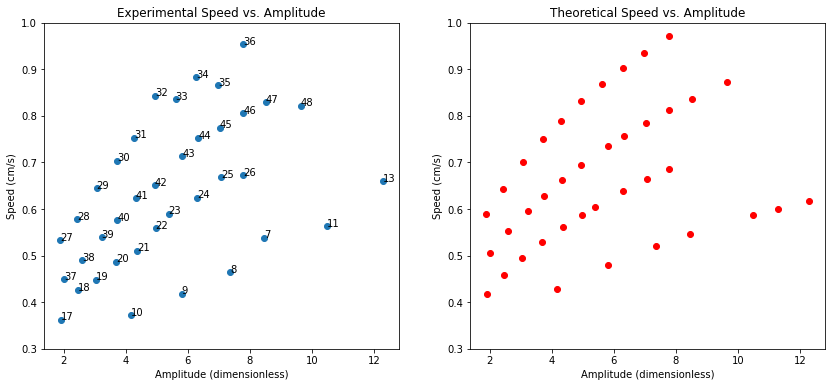

In [69]:
#PLOTTING
plt.figure(figsize = (14,6))

# experimental speeds
plt.subplot(1,2,1)
x,y,z = zip(*speeds_list2)
plt.scatter(x, y)

z = list(z)
z = [str(num) for num in z]
for i, dataNum in enumerate(z):
    plt.text(x[i], y[i], dataNum)

plt.ylabel('Speed (cm/s)')
plt.ylim(.3,1)
plt.xlabel('Amplitude (dimensionless)')
plt.title('Experimental Speed vs. Amplitude')

# theoretical speeds
plt.subplot(1,2,2)
theo_a0, theo_speed, dataset = zip(*scaled_theos_list)
plt.plot(theo_a0, theo_speed, 'o', c = 'red')
plt.ylim(.3,1)
plt.ylabel('Speed (cm/s)')
plt.xlabel('Amplitude (dimensionless)')
plt.title('Theoretical Speed vs. Amplitude')

plt.show()

Observe pattern in the experiment/dataset numbers: 
* There are three speeds per roughly the same amplitude. We interpret this to be three trials per roughly equal experimental amplitude, each with different speed scales U0, corresponding to different viscocities of the conduit liquid.

In [46]:
# can see this by pulling the A0 and U0 values from three datasets with solitons of similar amplitude

dict31 = sp.loadmat('expData31.mat')
a031 = dict31['A0']
u031 = dict31['U0']

dict41 = sp.loadmat('expData41.mat')
a041 = dict41['A0']
u041 = dict41['U0']

dict21 = sp.loadmat('expData21.mat')
a021 = dict21['A0']
u021 = dict21['U0']

print(a031, a041, a021)
print(u031, u041, u021)

[[4.28]] [[4.32]] [[4.37]]
[[0.23623145]] [[0.19764541]] [[0.16704086]]


**Make a speeds_list for the highest, middle, and lowest**

In [16]:
speeds_list_top = [speeds_list2[i] for i in range(len(speeds_list2)) if speeds_list2[i][2] in range(27,37)]
# speeds_list_top

In [17]:
speeds_list_middle = [speeds_list2[i] for i in range(len(speeds_list2)) if speeds_list2[i][2] in range(37,49)]
# speeds_list_middle

In [18]:
speeds_list_bottom = [speeds_list2[i] for i in range(len(speeds_list2)) if speeds_list2[i][2] in range(17,27)]
# speeds_list_bottom

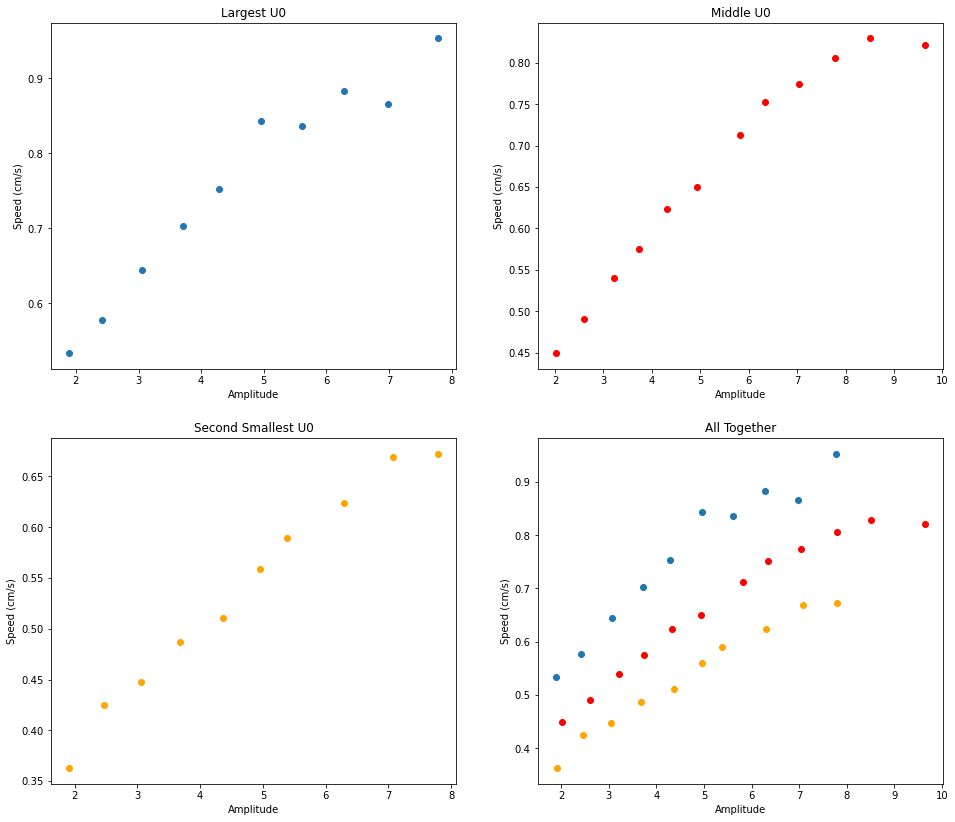

In [70]:
#PLOTTING
plt.figure(figsize = (16,14))

# experimental speeds, top
plt.subplot(2,2,1)
x,y,z = zip(*speeds_list_top)
plt.scatter(x, y)
plt.ylabel('Speed (cm/s)')
plt.xlabel('Amplitude')
plt.title('Largest U0')

# experimental speeds, middle
plt.subplot(2,2,2)
x,y,z = zip(*speeds_list_middle)
plt.scatter(x, y, c = 'red')
plt.ylabel('Speed (cm/s)')
plt.xlabel('Amplitude')
plt.title('Middle U0')

# experimental speeds, bottom
plt.subplot(2,2,3)
x,y,z = zip(*speeds_list_bottom)
plt.scatter(x, y, c = 'orange')
plt.ylabel('Speed (cm/s)')
plt.xlabel('Amplitude')
plt.title('Second Smallest U0')

# experimental speeds, all together
plt.subplot(2,2,4)
x,y,z = zip(*speeds_list_top)
plt.scatter(x, y)
x,y,z = zip(*speeds_list_middle)
plt.scatter(x, y, c = 'red')
x,y,z = zip(*speeds_list_bottom)
plt.scatter(x, y, c = 'orange')
plt.ylabel('Speed (cm/s)')
plt.xlabel('Amplitude')
plt.title('All Together')

plt.show()

## Propogating error for theoretical speeds
* Using the general formula for error propagation

In [71]:
# Take the derivative of c(a)
from sympy import *
a = Symbol('a')
c = (a**2 * sym.log(a**2) - a**2 + 1) / ((a-1)**2)
derivative_c = c.diff(a)
derivative_c

2*a*log(a**2)/(a - 1)**2 - 2*(a**2*log(a**2) - a**2 + 1)/(a - 1)**3

In [72]:
# Take the derivative of c(a)
from sympy import *
a = Symbol('a')
c = (a**2 * sym.log(a**2) - a**2 + 1) / ((a-1)**2)
derivative_c = c.diff(a)
derivative_c

# define the derivative c(a)
def c_prime(a0):
    top = 2*(-2*np.log(a0) + a0**2 -1)
    bottom = (a0-1)**3
    return top/bottom

In [73]:
c_primes = []
for a0 in a0_list:
    c_primes.append((a0[1], c_prime(a0[1])))

In [32]:
c_primes.sort()        # smaller values of a0 have a greater value of c_prime(a0) causing a greater uncertainty
# c_primes

In [98]:
c_prime(5.38)

0.5850221163250271

In [99]:
dict43 = sp.loadmat('expData43.mat')
a0 = dict43['A0'][0,0]
a0_error = dict43['A0_error'][0,0]
u0 = dict43['U0'][0,0]
c = (a0**2 * np.log(a0**2) - a0**2 + 1) / ((a0-1)**2)

c_error = np.absolute(c_prime(a0)) * a0_error * u0
c_error

0.031081502211846163

### Plotting only the datasets that the function worked best on

**Create list of all the theoretical errors for the most compatilbe datasets**

In [74]:
best_theo_error_list = []
for elm in [43, 36, 28, 18, 10,  7, 38, 30, 29, 27, 22, 31, 11,  8]:
    if elm < 10:
        num = str(0) + str(elm)
    else:
        num = str(elm)
    
    data = 'expData' + num + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_err = dictionary['A0_error'][0,0]
    u0 = dictionary['U0'][0,0]
    
    error = np.absolute(c_prime(a0)) * a0_err * u0

    best_theo_error_list.append( (a0, error, elm) )

In [75]:
best_theo_error_list.sort()
# best_theo_error_list

Hand picked the datasets that the function worked best on, datasets where the slope of the line of best fit matched most closely the leading edge of the contour plot. 
* best datasets: (43, 36, 28, 18, 10,  7, 38, 30, 29, 27, 22, 31, 11,  8)

In [76]:
scaled_theos_list_best = [scaled_theos_list[i] for i in range(len(scaled_theos_list)) if scaled_theos_list[i][2] in (43, 36, 28, 18, 10,  7, 38, 30, 29, 27, 22, 31, 11,  8)]
# scaled_theos_list_best

In [77]:
speeds_list_best = [speeds_list2[i] for i in range(len(speeds_list2)) if speeds_list2[i][2] in (43, 36, 28, 18, 10,  7, 38, 30, 29, 27, 22, 31, 11,  8)]
# speeds_list_best

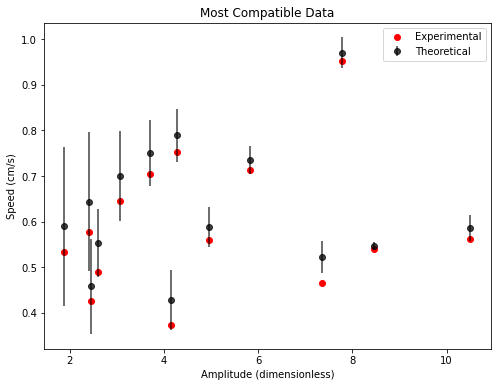

In [79]:
# PLOTTING
plt.figure(figsize = (8,6))

# experimental speeds
x,y,data = zip(*speeds_list_best)
plt.scatter(x, y, c = 'red', label = 'Experimental')

# theoretical speeds
theo_a0, theo_speed, dataset = zip(*scaled_theos_list_best)
errors = list(zip(*best_theo_error_list))[1]

plt.errorbar(theo_a0, theo_speed, yerr = errors, fmt='o', c = 'k', ecolor = 'k', alpha = .75, label = 'Theoretical')

plt.ylabel('Speed (cm/s)')
plt.xlabel('Amplitude (dimensionless)')
plt.title('Most Compatible Data')
plt.legend()

plt.show()

### Plot of middle U0 datasets with theoreticals

In [38]:
scaled_theos_list_middle = [scaled_theos_list[i] for i in range(len(scaled_theos_list)) if scaled_theos_list[i][2] in range(37,49)]
# scaled_theos_list_middle

In [39]:
# make a theoretical error bar list for middle U0 values
middle_theo_error_list = []
for elm in range(37,49):    # experiment numbers of trials with "middle" U0 values
    if elm < 10:
        num = str(0) + str(elm)
    else:
        num = str(elm)
    
    data = 'expData' + num + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_err = dictionary['A0_error'][0,0]
    u0 = dictionary['U0'][0,0]
    
    error = np.absolute(c_prime(a0)) * a0_err * u0

    middle_theo_error_list.append( (a0, error, elm) )

In [80]:
# middle_theo_error_list

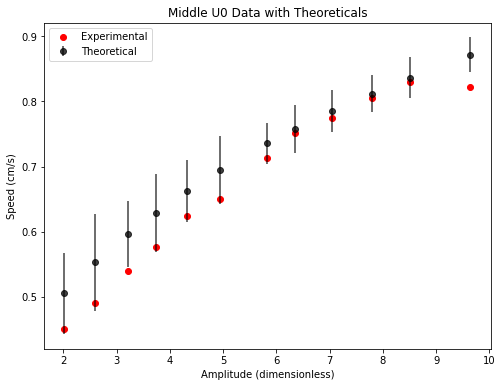

In [81]:
#PLOTTING
# experimental
plt.figure(figsize = (8,6))
x,y,z = zip(*speeds_list_middle)
plt.scatter(x, y, c = 'red', label = 'Experimental')
plt.title('Middle U0 Data with Theoreticals')

# theoretical
theo_a0, theo_speed, dataset = zip(*scaled_theos_list_middle)
errors = list(zip(*middle_theo_error_list))[1]
plt.errorbar(theo_a0, theo_speed, yerr = errors, fmt='o', c = 'k', ecolor = 'k', alpha = .75, label = 'Theoretical')


plt.ylabel('Speed (cm/s)')
plt.xlabel('Amplitude (dimensionless)')
plt.legend()
plt.show()

## Modified function
New version of the function tries to correct the trend we can see in the lines of best fit made by the original function. Many of these lines of best fit for many of the datasets are steeper than they should be when compared to the apparent slope of the leading edge of the corresponding countour plot. To correct this we try to eliminate indices from the solitonIdxs list if the length of the column list is only one. This will hopefully help to correct this error trend.

In [51]:
def compute_soliton_speed2(dictionary):
    mat = dictionary['Amat']
    times = mat.shape[0]
    distances = mat.shape[1]
    a0 = dictionary['A0'][0,0]
    a0_error = dictionary['A0_error'][0,0]
    solitonAmpRange = ((a0 - a0_error), (a0 + a0_error))
    
    # first get possible soliton indexes
    fullWaveIdxs = []                    
    for i in range(times):
        for j in range(distances):
            if (mat[i,j]>solitonAmpRange[0]) & (mat[i,j]<solitonAmpRange[1]):
                fullWaveIdxs.append((i,j))
                
    # next, get the index with the smallest time coordinate from every column where there is a soliton
    solitonIdxs = []           
    columns = [idx[1] for idx in fullWaveIdxs]                  
    for d in set(columns):
        column_idxs = [idx for idx in fullWaveIdxs if idx[1] == d]
        if len(column_idxs) != 1:
            solitonIdxs.append(min(column_idxs))
        
    # change order of the coordinates for each soliton index to switch from matrix indexing to cartesian coordinates
    solitonIdxs = [(idx[1],idx[0]) for idx in solitonIdxs]

    # separate the time values and the distance values for use of polyfit() function
    xvals = [idx[0] for idx in solitonIdxs]
    yvals = [idx[1] for idx in solitonIdxs]
    m, b = np.polyfit(xvals, yvals, deg = 1)
    
    # calculating real_speed by adjusting scales of the matrix indices
    index_speed = 1/m # zidx / tidx
    cm_per_zidx = dictionary['z_vec'][-1][-1] / dictionary['z_vec'].size
    real_distance = index_speed * cm_per_zidx
    sec_per_tidx = dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size
    
    
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size > 0:  # in case the time vector has negative time values
        average = 1.2371625245444737
        sec_per_tidx = average
    
    real_speed = real_distance / sec_per_tidx  # cm / sec
    
    # return all useful information for tracking speed and for plotting 
    return {'real_speed':real_speed, 'index_speed':index_speed,
            'solitonIdxs':solitonIdxs, 'xvals':xvals, 'yvals':yvals, 'b':b}

In [52]:
speeds_list2 = []

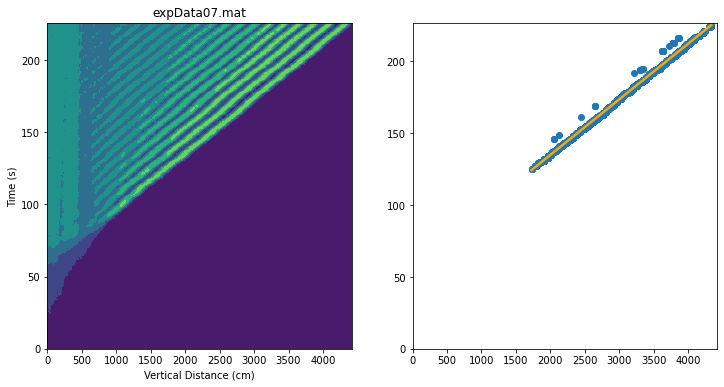

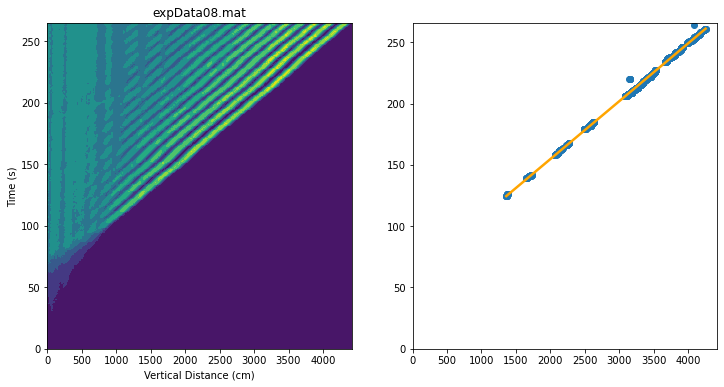

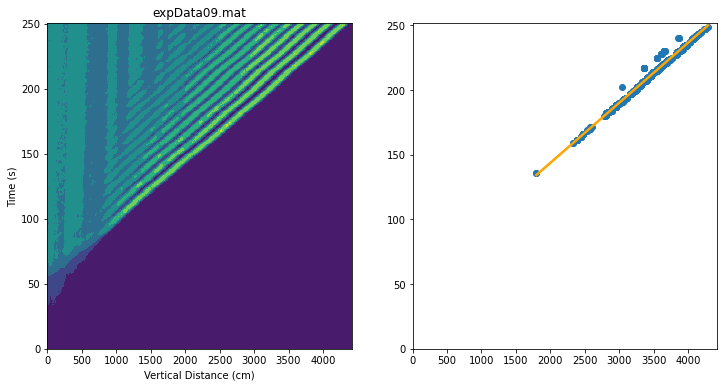

In [53]:
# data sets [7-9]
for num in range(7,10):
    data = 'expData0' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    
    new_dict = compute_soliton_speed2(dictionary)
    
    # append speed to list
    speeds_list2.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.xlabel('Vertical Distance (cm)')
    plt.ylabel('Time (s)')
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()    

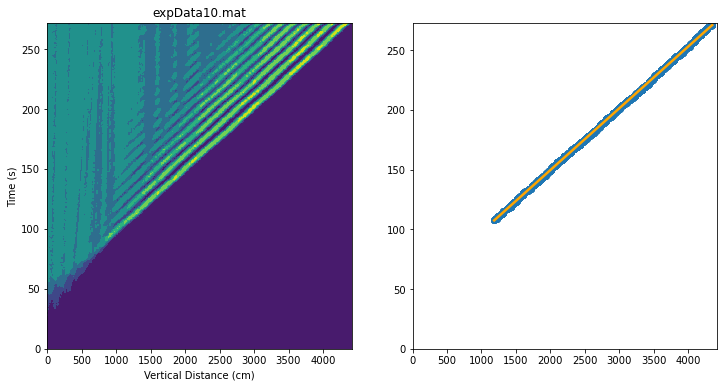

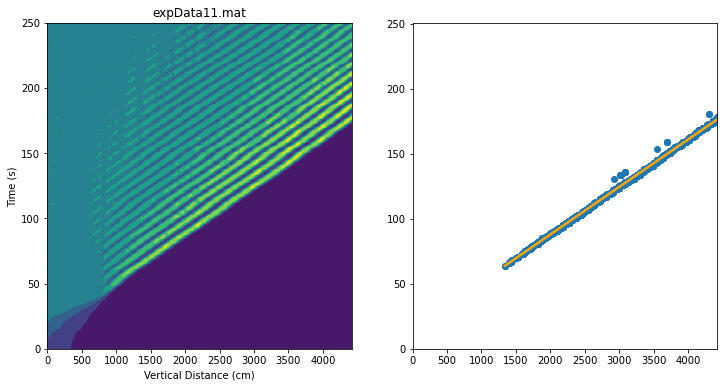

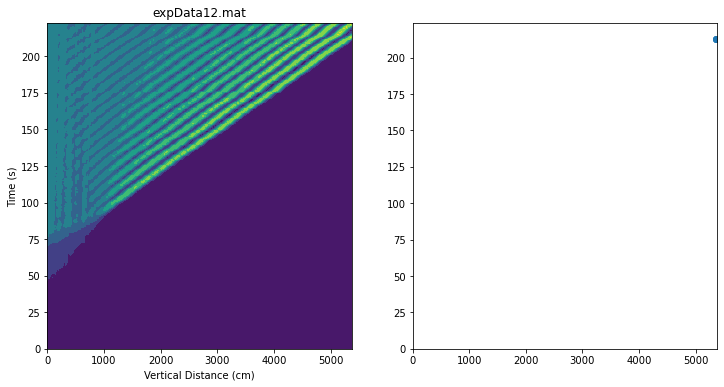

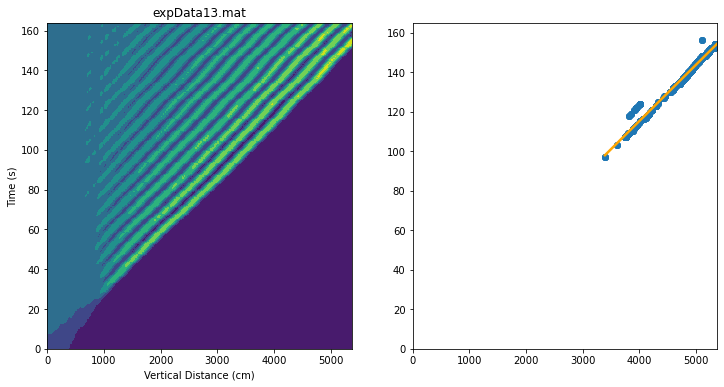

In [55]:
# data sets [10-13]
for num in range(10,14):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    
    new_dict = compute_soliton_speed2(dictionary)
    
    # append speed to list
    speeds_list2.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.xlabel('Vertical Distance (cm)')
    plt.ylabel('Time (s)')
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()

In [56]:
speeds_list2.sort()
speeds_list2

[(4.16, 0.3715453770214089, 10),
 (5.8, 0.4150023572599132, 9),
 (7.36, 0.46249557721330886, 8),
 (8.46, 0.5343338696889031, 7),
 (10.5, 0.5597570681639027, 11),
 (11.3, 687541475423.8772, 12),
 (12.3, 0.6233098749805718, 13)]

In [ ]:
# for dataset12 speed is 107 for original function

**At this point, notice that the modified function is not making enough of a difference in removing outliers from the SolitonIdxs to make a change from the original implementation.**

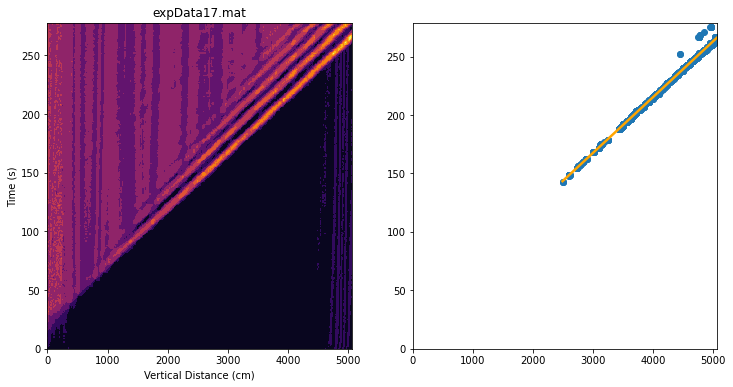

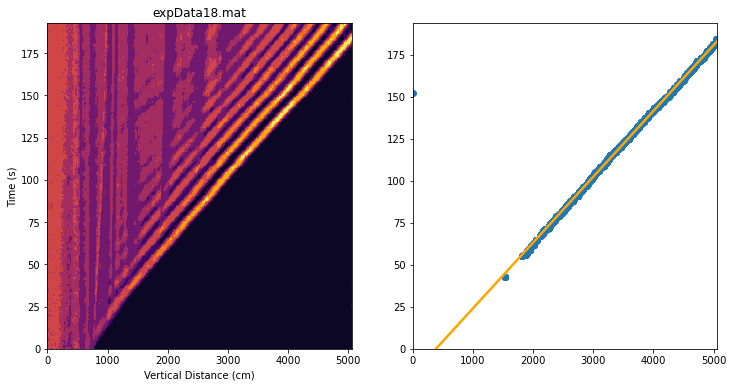

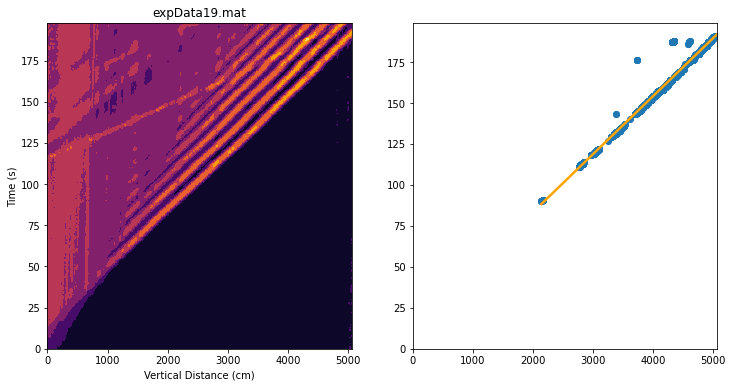

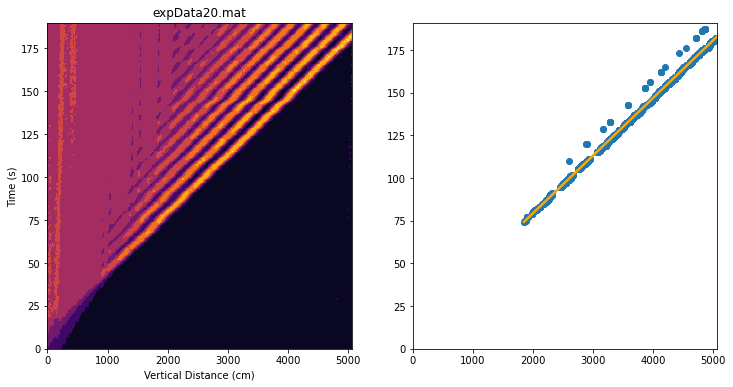

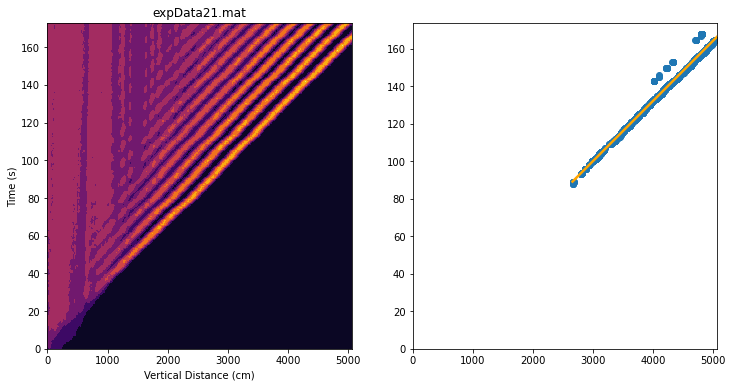

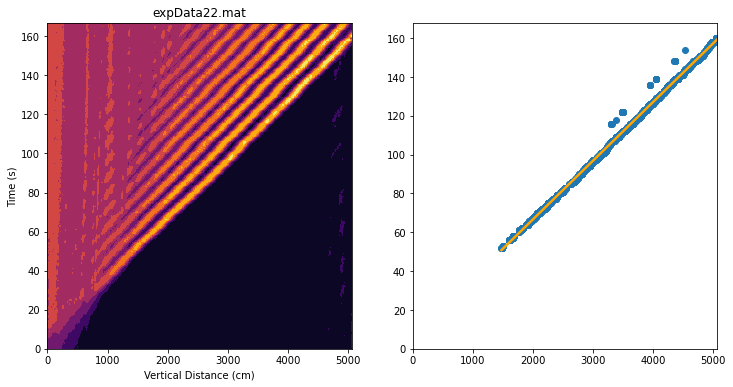

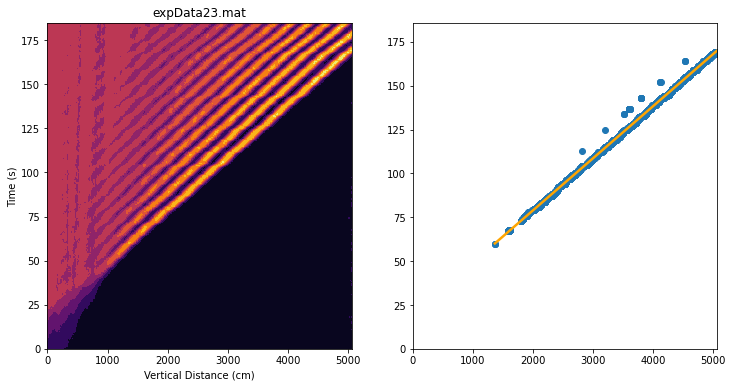

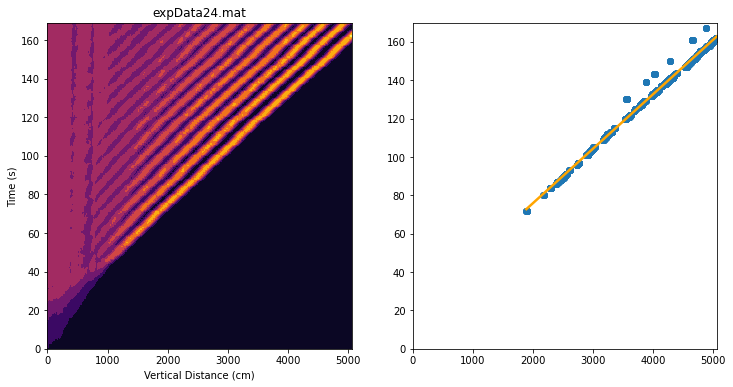

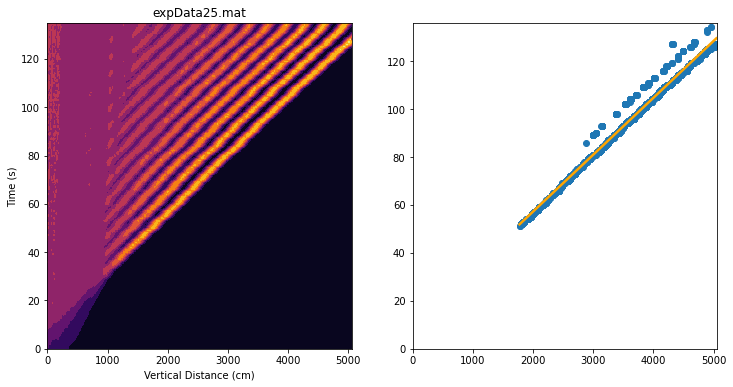

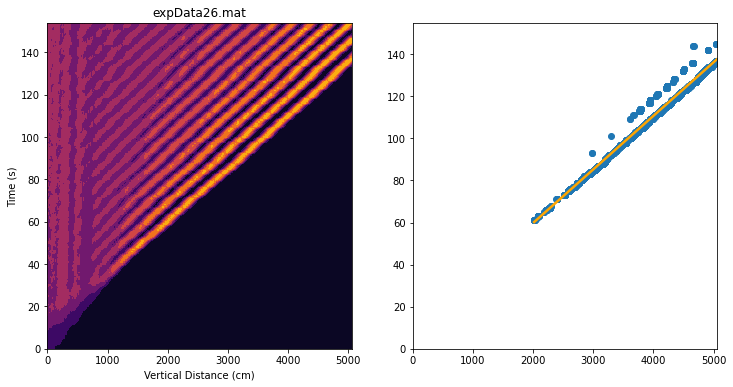

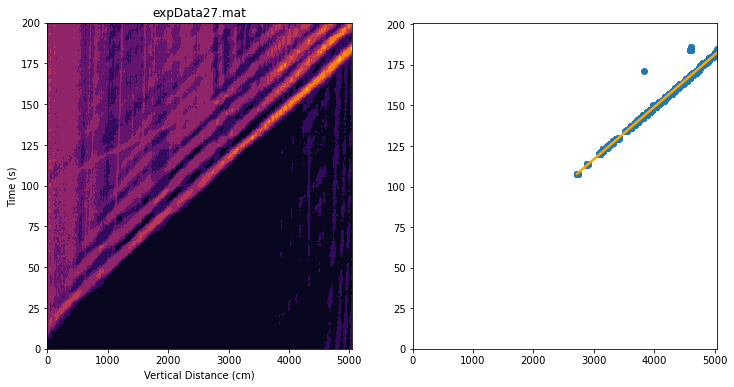

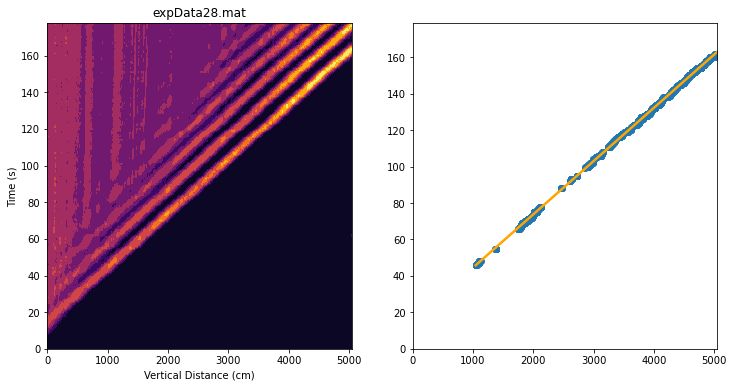

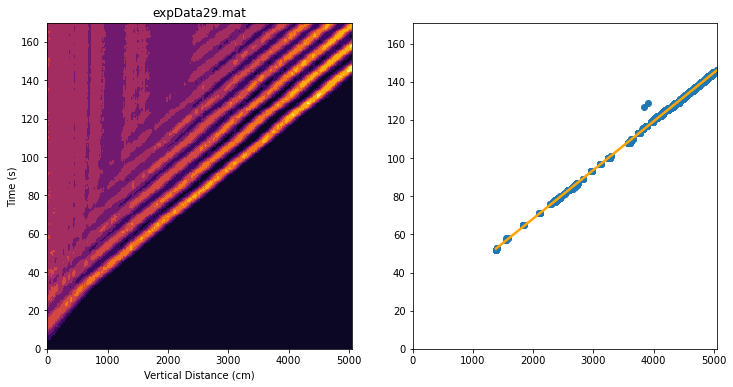

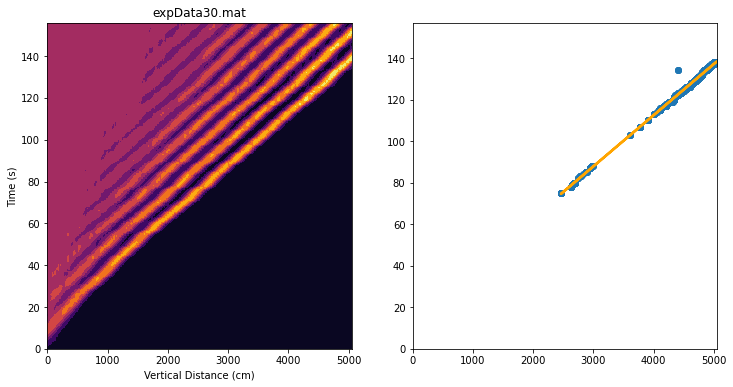

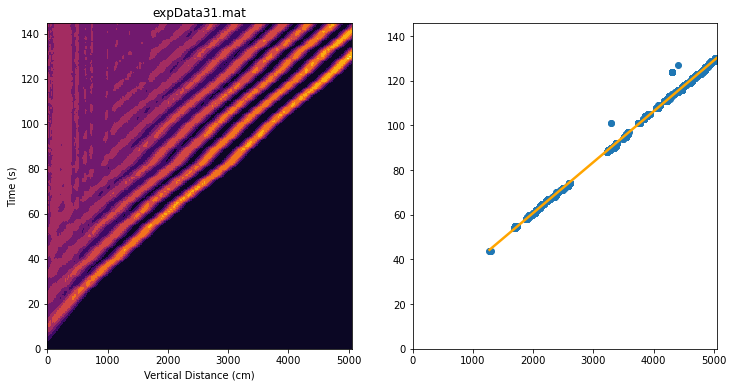

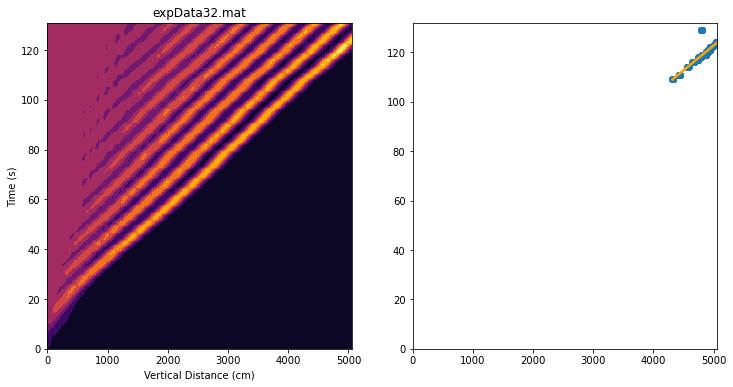

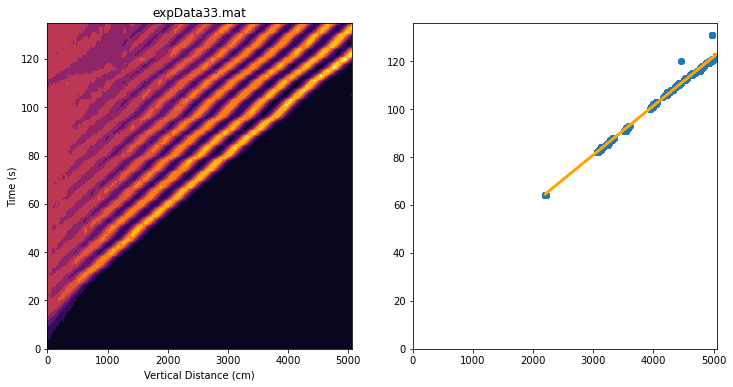

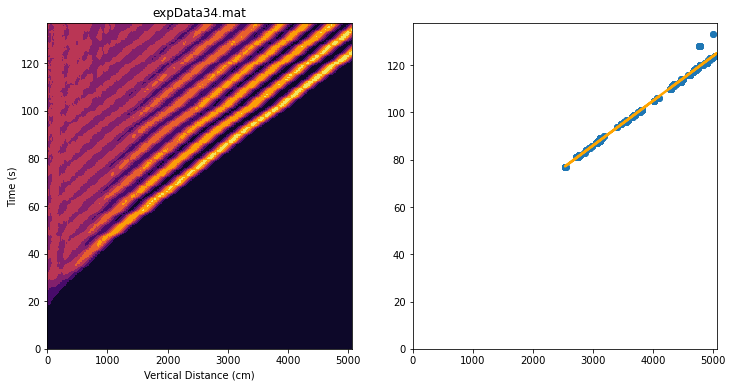

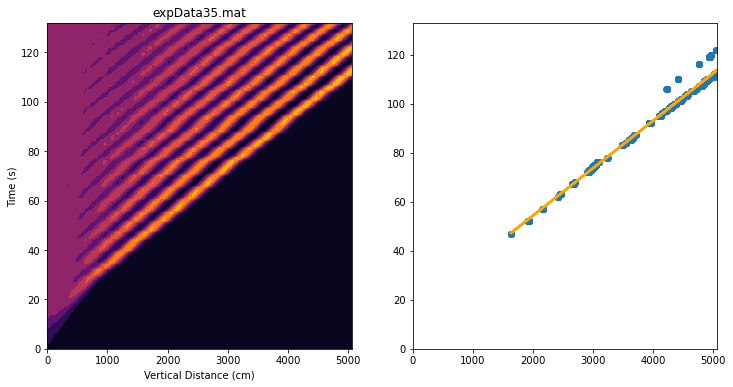

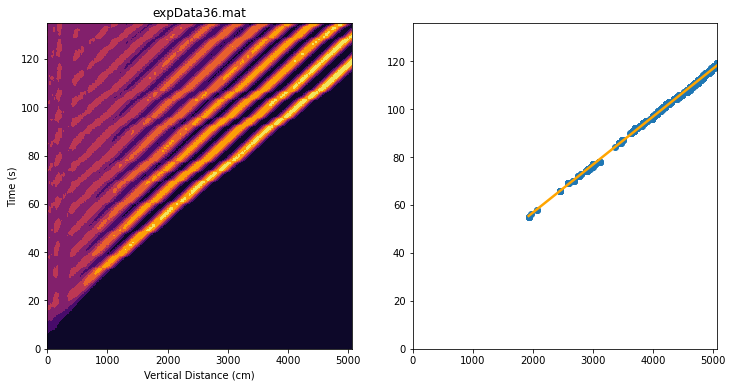

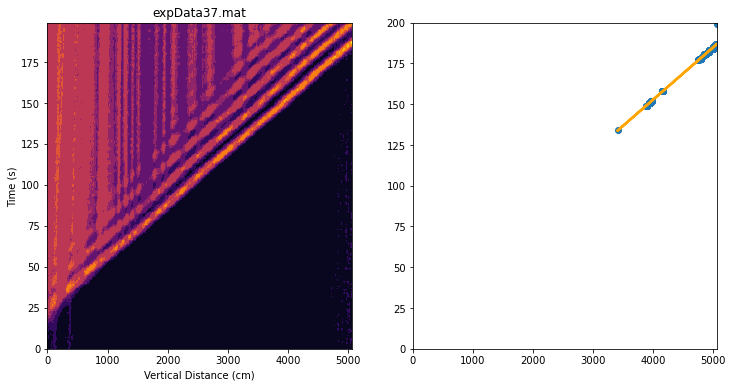

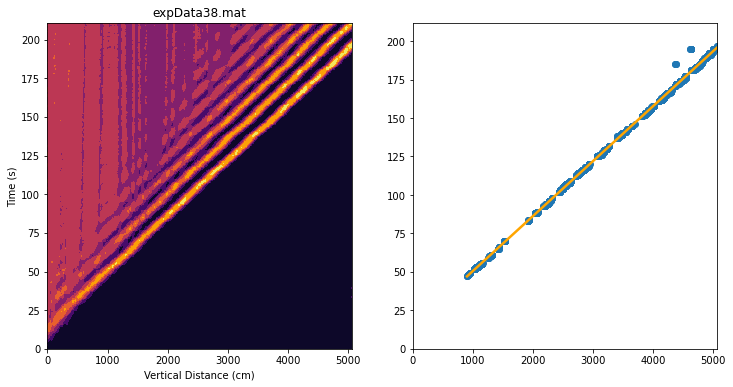

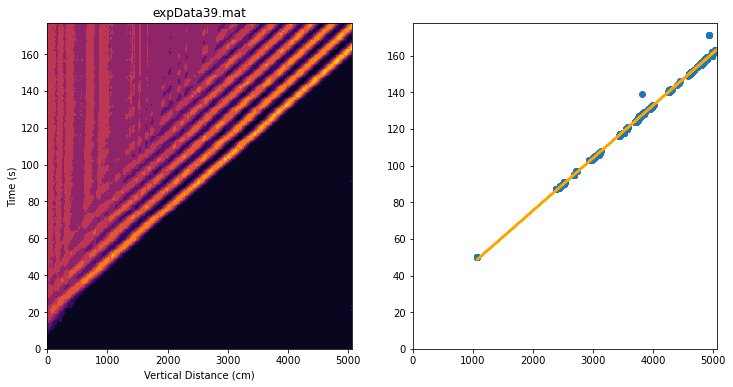

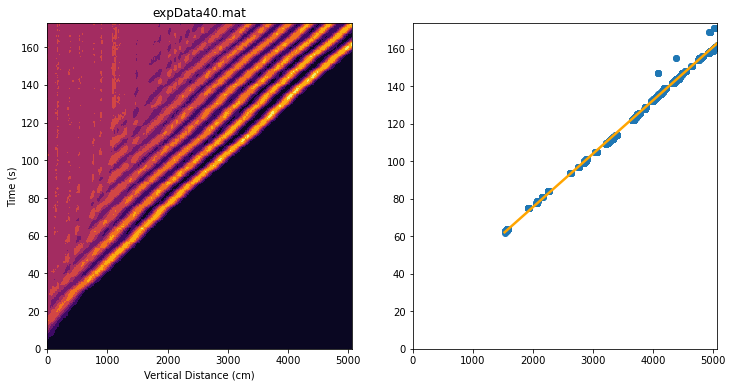

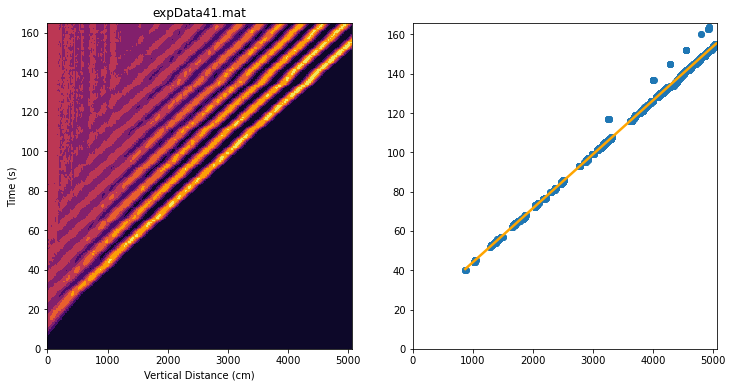

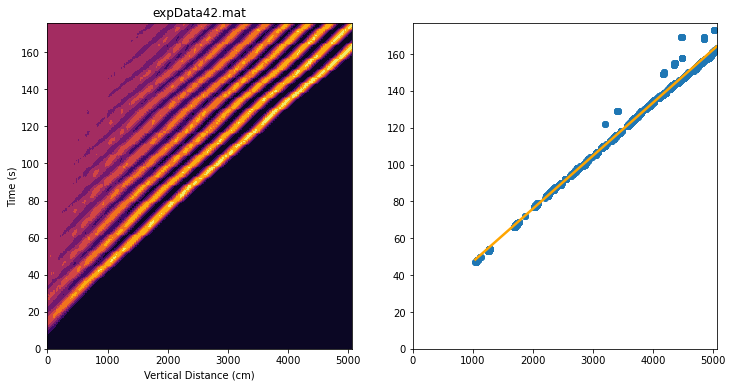

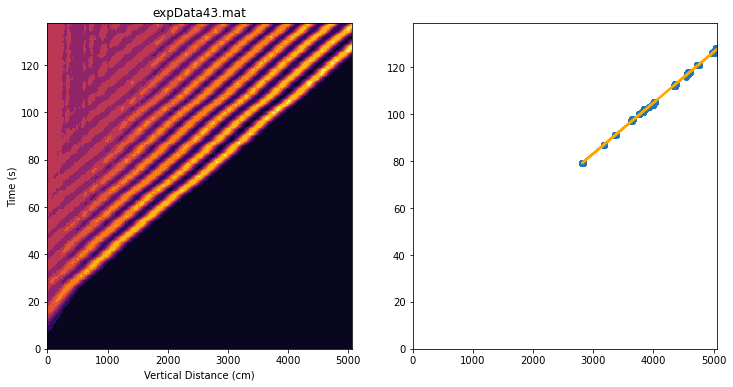

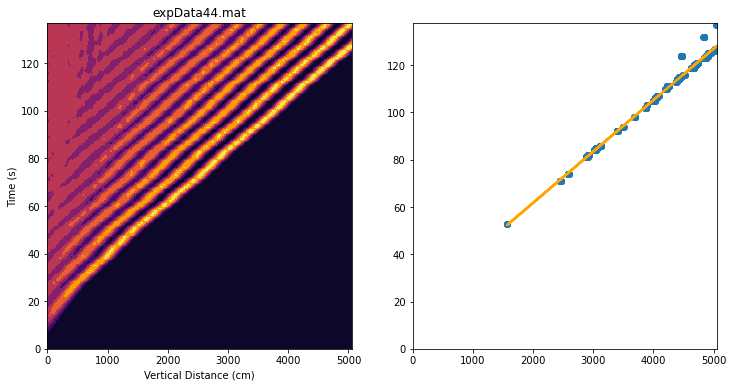

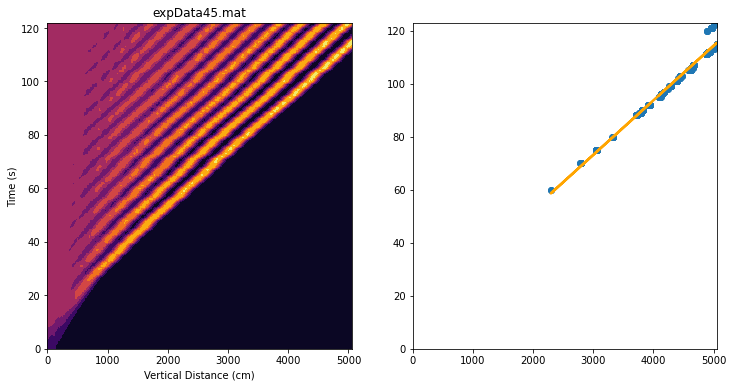

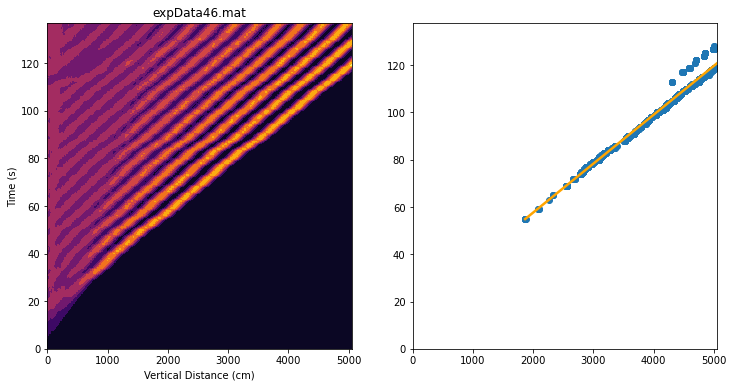

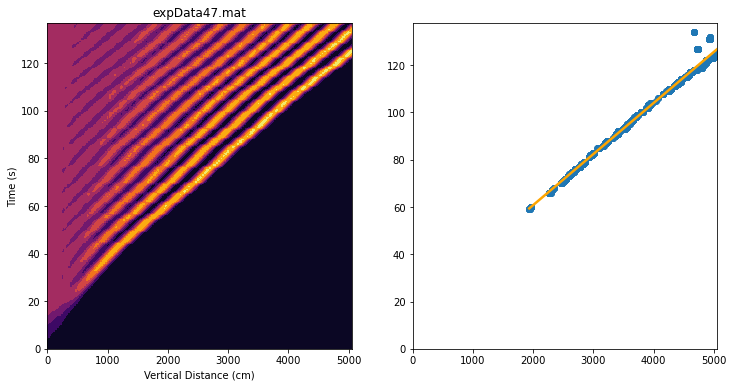

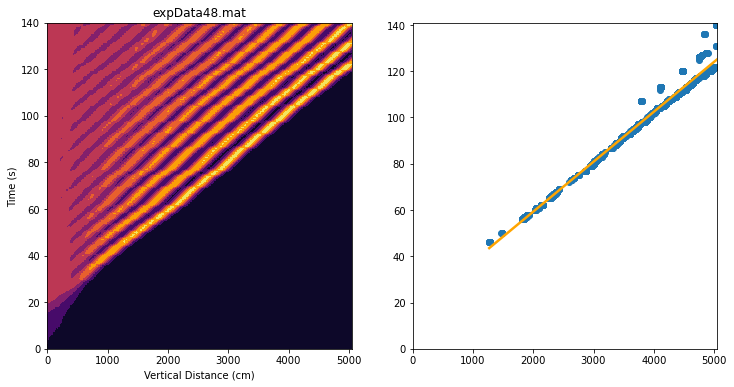

In [206]:
# data sets [17-48]
for num in range(17,49):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    
    new_dict = compute_soliton_speed2(dictionary)
    
    # append speed to list
    speeds_list2.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.xlabel('Vertical Distance (cm)')
    plt.ylabel('Time (s)')
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()

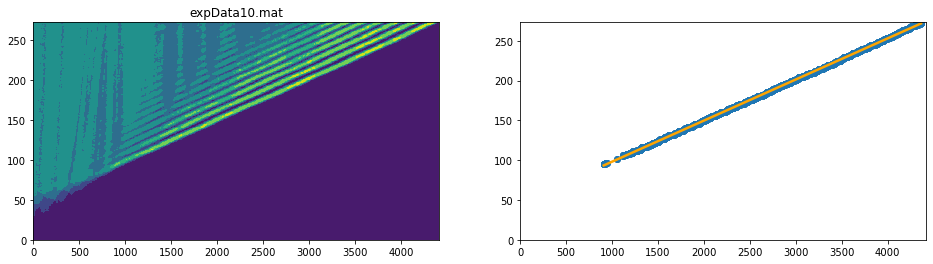

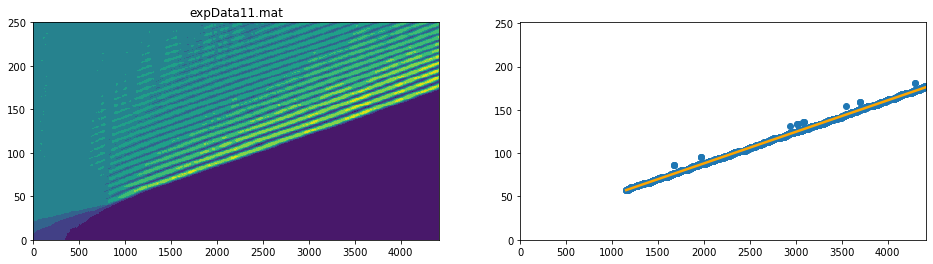

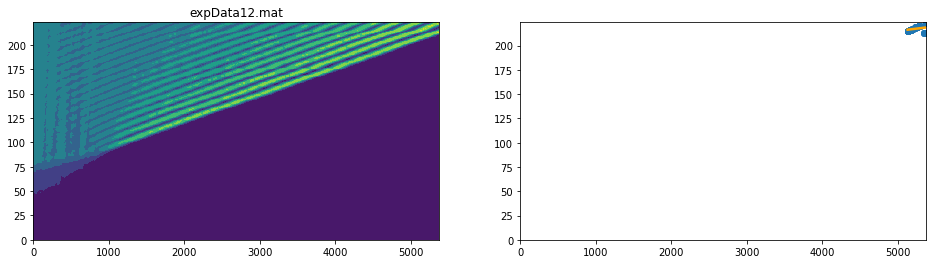

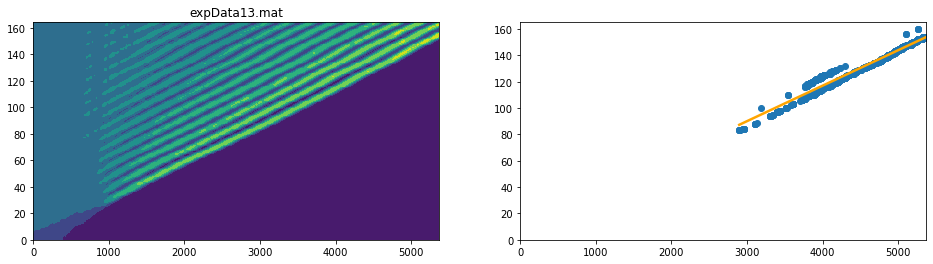

In [5]:
speeds_list = []
a0_list = []
u0_list = []

# data sets [7-9]
for num in range(7,10):
    data = 'expData0' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_list.append((num, a0))
    u0_list.append(dictionary['U0'][0,0])
    
    new_dict = compute_soliton_speed(dictionary)
    
    # append speed to list
    speeds_list.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (16, 4))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show() 

# data sets [10-13]
for num in range(10,14):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_list.append((num, a0))
    u0_list.append(dictionary['U0'][0,0])
    
    new_dict = compute_soliton_speed(dictionary)
    
    # append speed to list
    speeds_list.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (16, 4))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])

    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()
    
# data sets [17-48]
for num in range(17,49):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_list.append((num, a0))
    u0_list.append(dictionary['U0'][0,0])
    
    new_dict = compute_soliton_speed(dictionary)
    
    # append speed to list
    speeds_list.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (16, 4))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])

    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()